# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression, make_classification
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import xgboost

from geopy.distance import vincenty
from datetime import datetime as dt
from haversine import haversine
from sklearn.decomposition import PCA

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading & Merging the Data

In [2]:
pd.set_option('max_columns', 100)
pd.set_option('max_colwidth', 999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.precision',10)

In [3]:
train = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')

weather = weather.iloc[56:]

In [4]:
def choose_station(lat, long):
    dist_ohare = abs((41.995 - lat) + (-87.933 - long))
    dist_midway = abs((41.786 - lat) + (-87.752 - long)) 
    if dist_ohare < dist_midway:
        return 1
    else:
        return 2

In [5]:
train['Station'] = train.apply(lambda x: choose_station(x['Latitude'], x['Longitude']), axis=1)

In [6]:
train = pd.merge(train, weather, on=['Date','Station'])

# EDA & Cleaning

In [7]:
le = LabelEncoder()
le.fit(train['Species'])
train['Species'] = le.transform(train['Species'])
le.fit(train['Trap'])
train['Trap'] = le.transform(train['Trap'])
le.fit(train['Water1'])
train['Water1'] = le.transform(train['Water1'])

train.replace('M', np.NaN, inplace=True, axis=1)
train.replace('  T', np.NaN, inplace=True, axis=1)

train['Sunrise'].replace('-', np.nan, inplace=True, axis=1)
train['Sunrise'].fillna(str('0421'), inplace=True)
train['Sunset'].replace('-', np.nan, inplace=True, axis=1)
train['Sunset'].fillna(1919, inplace=True)
train['CodeSum'].replace(r'^\s*$', 'Moderate', regex=True, inplace=True, axis=1)

train['Tavg'] = train['Tavg'].astype('float64')
train['Depart'] = train['Depart'].astype('float64')
train['WetBulb'] = train['WetBulb'].astype('float64')
train['Depth'] = train['Depth'].astype('float64')
train['SnowFall'] = train['SnowFall'].astype('float64')
train['PrecipTotal'] = train['PrecipTotal'].astype('float64')
train['StnPressure'] = train['StnPressure'].astype('float64')
train['SeaLevel'] = train['SeaLevel'].astype('float64')
train['AvgSpeed'] = train['AvgSpeed'].astype('float64')
train['Heat'] = train['Heat'].astype('int64')
train['Cool'] = train['Cool'].astype('int64')
train['Sunrise'] = train['Sunrise'].astype('int64')
train['Sunset'] = train['Sunset'].astype('int64')

train['Depth'].interpolate(method='linear', inplace=True)
train['SnowFall'].interpolate(method='linear', inplace=True)
train['PrecipTotal'].interpolate(method='linear', inplace=True)
train['StnPressure'].interpolate(method='linear', inplace=True)
train['Depart'].interpolate(method='linear', inplace=True)
train['WetBulb'].interpolate(method='linear', inplace=True)

# Replace all TSRA (thunderstorm + rain) with 'TR' to be able to better split values
train['CodeSum'] = train['CodeSum'].map(lambda x: (x.replace('TSRA', 'TR')))
train['CodeSum_1'] = train['CodeSum'].apply(lambda x: x[0:2])
train['CodeSum_2'] = train['CodeSum'].apply(lambda x: x[3:5])
le.fit(train['CodeSum_1'])
train['CodeSum_1'] = le.transform(train['CodeSum_1'])
le.fit(train['CodeSum_2'])
train['CodeSum_2'] = le.transform(train['CodeSum_2'])

train['Year'] = train['Date'].apply(lambda x: x[0:4])
train = pd.get_dummies(train, columns=['Year'])

# Reinstantiating column as it was deleted in get_dummies
train['Year'] = train['Date'].apply(lambda x: x[0:4])
train['Year'] = train['Year'].astype('int64')

train['OverAvgNumMos'] = train['NumMosquitos'].apply(lambda x: 1 if x >= 13 else 0)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


# Identifying Clusters

**Creating latitude & longitude clusters for each year of training data where WNV present.**

In [9]:
present = train.loc[train['WnvPresent'] == 1]

train['Longitude_wnv'] = present['Longitude']
train['Latitude_wnv'] = present['Latitude']
train['2007_wnv'] = present['Year_2007']
train['2009_wnv'] = present['Year_2009']
train['2011_wnv'] = present['Year_2011']
train['2013_wnv'] = present['Year_2013']

train['2007_wnv'].fillna(0, inplace = True)
train['2009_wnv'].fillna(0, inplace = True)
train['2011_wnv'].fillna(0, inplace = True)
train['2013_wnv'].fillna(0, inplace = True)

In [12]:
wnv_present_2007 = train.loc[train['2007_wnv'] == 1]
train['Longitude_wnv_2007'] = wnv_present_2007['Longitude']
train['Latitude_wnv_2007'] = wnv_present_2007['Latitude']
train['Longitude_wnv_2007'].fillna(0, inplace = True)
train['Latitude_wnv_2007'].fillna(0, inplace = True)

wnv_present_2009 = train.loc[train['2009_wnv'] == 1]
train['Longitude_wnv_2009'] = wnv_present_2009['Longitude']
train['Latitude_wnv_2009'] = wnv_present_2009['Latitude']
train['Longitude_wnv_2009'].fillna(0, inplace = True)
train['Latitude_wnv_2009'].fillna(0, inplace = True)

wnv_present_2011 = train.loc[train['2011_wnv'] == 1]
train['Longitude_wnv_2011'] = wnv_present_2011['Longitude']
train['Latitude_wnv_2011'] = wnv_present_2011['Latitude']
train['Longitude_wnv_2011'].fillna(0, inplace = True)
train['Latitude_wnv_2011'].fillna(0, inplace = True)

wnv_present_2013 = train.loc[train['2013_wnv'] == 1]
train['Longitude_wnv_2013'] = wnv_present_2013['Longitude']
train['Latitude_wnv_2013'] = wnv_present_2013['Latitude']
train['Longitude_wnv_2013'].fillna(0, inplace = True)
train['Latitude_wnv_2013'].fillna(0, inplace = True)

In [13]:
train_2007 = train[train['Longitude_wnv_2007'] != False]
print('Confirmed cases of WNV in 2007: ', train_2007.shape[0])

train_2009 = train[train['Longitude_wnv_2009'] != False]
print('Confirmed cases of WNV in 2009: ', train_2009.shape[0])

train_2011 = train[train['Longitude_wnv_2011'] != False]
print('Confirmed cases of WNV in 2011: ', train_2011.shape[0])

train_2013 = train[train['Longitude_wnv_2013'] != False]
print('Confirmed cases of WNV in 2013: ', train_2013.shape[0])

Confirmed cases of WNV in 2007:  236
Confirmed cases of WNV in 2009:  19
Confirmed cases of WNV in 2011:  57
Confirmed cases of WNV in 2013:  239


**Finding centroids (10 for 200+ cases in a given year or 5 for under 100 cases)**

    Longitude_2007  Latitude_2007
1          -87.579         41.726
2          -87.793         41.990
3          -87.655         41.827
4          -87.695         41.927
5          -87.700         41.678
6          -87.537         41.683
7          -87.748         41.793
8          -87.666         41.729
9          -87.600         41.673
10         -87.808         41.945
Silhouette Score:  0.9901926252114486


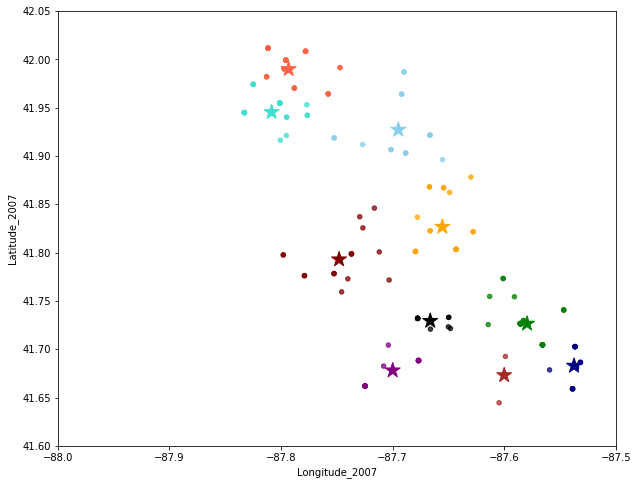

In [14]:
kmeans_2007 = KMeans(n_clusters=11, random_state=42)
model_2007 = kmeans_2007.fit(train[['Longitude_wnv_2007', 'Latitude_wnv_2007']])
train['cluster_predicted_2007'] = model_2007.labels_

centroids_2007 = pd.DataFrame(model_2007.cluster_centers_, columns=['Longitude_2007', 'Latitude_2007'])
centroids_2007.drop([0], inplace=True)
print(centroids_2007)

colors = ["w", "green", "tomato", "orange", "skyblue", "purple", "navy", "maroon", "black", "brown", "turquoise"] 
# white is for non-present WNV
train['cluster_color_2007'] = train['cluster_predicted_2007'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", x="Longitude_wnv_2007", y="Latitude_wnv_2007",
    figsize=(10,8), xlim=(-88, -87.5), ylim=(41.6, 42.05), 
    c=train['cluster_color_2007'], alpha=0.75)

centroids_2007.plot(kind="scatter", x="Longitude_2007", y="Latitude_2007", marker="*", 
    c=["green", "tomato", "orange", "skyblue", "purple", "navy", "maroon", "black", "brown", "turquoise"], 
    s=250, ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2007', 'Latitude_wnv_2007']], 
                                             train['cluster_predicted_2007']))

   Longitude_2009  Latitude_2009
1         -87.678         41.886
2         -87.901         41.971
3         -87.722         41.727
4         -87.572         41.705
5         -87.780         41.936
Silhouette Score:  0.9990879006533443


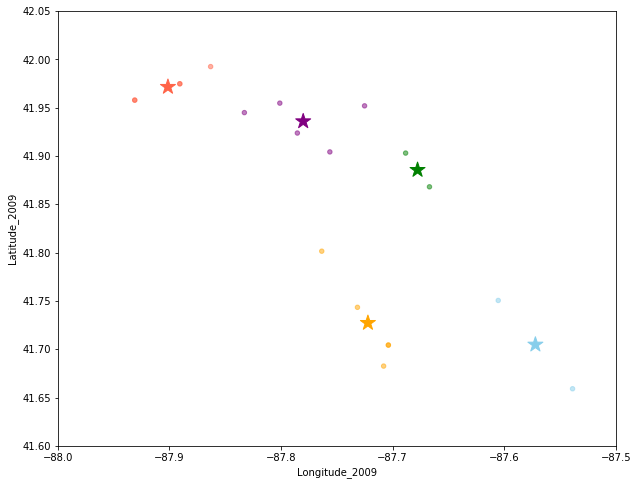

In [15]:
kmeans_2009 = KMeans(n_clusters=6, random_state=42)
model_2009 = kmeans_2009.fit(train[['Longitude_wnv_2009', 'Latitude_wnv_2009']])
train['cluster_predicted_2009'] = model_2009.labels_

centroids_2009 = pd.DataFrame(model_2009.cluster_centers_, columns=['Longitude_2009', 'Latitude_2009'])
centroids_2009.drop([0], inplace=True)
print(centroids_2009)

train['cluster_color_2009'] = train['cluster_predicted_2009'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", x="Longitude_wnv_2009", y="Latitude_wnv_2009",
    figsize=(10,8), xlim=(-88, -87.5), ylim=(41.6, 42.05),
    c=train['cluster_color_2009'], alpha=0.5)

centroids_2009.plot(kind="scatter", x="Longitude_2009", y="Latitude_2009", marker="*", 
    c=["green", "tomato", "orange", "skyblue", "purple"], 
    s=250, ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2009', 'Latitude_wnv_2009']], 
                                             train['cluster_predicted_2009']))

   Longitude_2011  Latitude_2011
1         -87.718         41.936
2         -87.903         41.969
3         -87.605         41.756
4         -87.730         41.753
5         -87.789         41.960
Silhouette Score:  0.9979362952747243


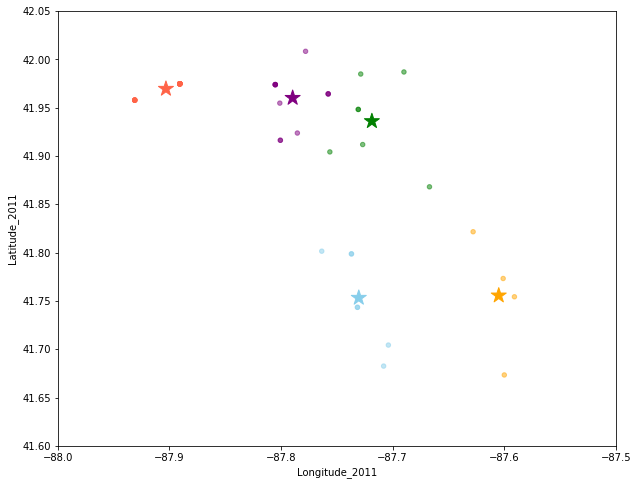

In [16]:
kmeans_2011 = KMeans(n_clusters=6, random_state=42)
model_2011 = kmeans_2011.fit(train[['Longitude_wnv_2011', 'Latitude_wnv_2011']])
train['cluster_predicted_2011'] = model_2011.labels_

centroids_2011 = pd.DataFrame(model_2011.cluster_centers_, columns=['Longitude_2011', 'Latitude_2011'])
centroids_2011.drop([0], inplace=True)
print(centroids_2011)

train['cluster_color_2011'] = train['cluster_predicted_2011'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", x="Longitude_wnv_2011", y="Latitude_wnv_2011",
    figsize=(10,8), xlim=(-88, -87.5), ylim=(41.6, 42.05),
    c=train['cluster_color_2011'], alpha=0.5)

centroids_2011.plot(kind="scatter", x="Longitude_2011", y="Latitude_2011", marker="*", 
    c=["green", "tomato", "orange", "skyblue", "purple"], 
    s=250, ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2011', 'Latitude_wnv_2011']], 
                                             train['cluster_predicted_2011']))

    Longitude_2013  Latitude_2013
1          -87.648         41.902
2          -87.888         41.976
3          -87.641         41.780
4          -87.719         41.902
5          -87.747         41.977
6          -87.682         41.704
7          -87.580         41.697
8          -87.738         41.772
9          -87.681         41.980
10         -87.802         41.957
Silhouette Score:  0.990145441163817


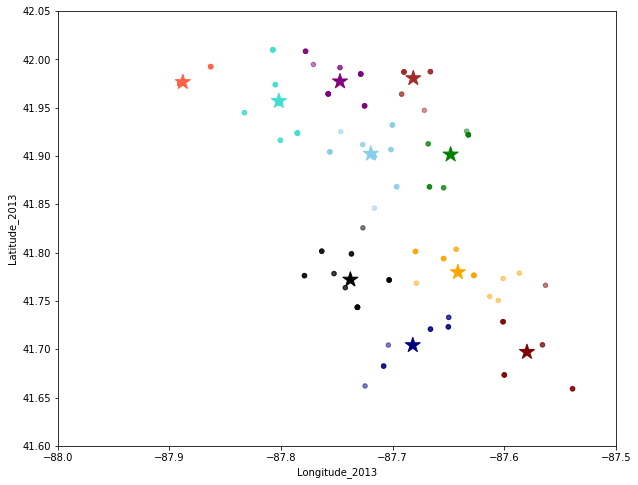

In [17]:
kmeans_2013 = KMeans(n_clusters=11, random_state=42)
model_2013 = kmeans_2013.fit(train[['Longitude_wnv_2013', 'Latitude_wnv_2013']])
train['cluster_predicted_2013'] = model_2013.labels_

centroids_2013 = pd.DataFrame(model_2013.cluster_centers_, columns=['Longitude_2013', 'Latitude_2013'])
centroids_2013.drop([0], inplace=True)
print(centroids_2013)

train['cluster_color_2013'] = train['cluster_predicted_2013'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", x="Longitude_wnv_2013", y="Latitude_wnv_2013",
    figsize=(10,8), xlim=(-88, -87.5), ylim=(41.6, 42.05),
    c = train['cluster_color_2013'], alpha=0.5)

centroids_2013.plot(kind="scatter", x="Longitude_2013", y="Latitude_2013", marker="*", 
    c=["green", "tomato", "orange", "skyblue", "purple", "navy", "maroon", "black", "brown", "turquoise"], 
    s=250, ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2013', 'Latitude_wnv_2013']],
                                             train['cluster_predicted_2013']))

# Incorporating Clusters/Centroids to Features

In [18]:
seven_centroids = [(41.726, -87.579),
                   (41.990, -87.793),
                   (41.827, -87.655),
                   (41.927, -87.695),
                   (41.678, -87.700),
                   (41.683, -87.537),
                   (41.793, -87.748),
                   (41.729, -87.666),
                   (41.673, -87.600),
                   (41.945, -87.808)]

nine_centroids = [(41.886, -87.768),
                  (41.971, -87.901),
                  (41.727, -87.722),
                  (41.705, -87.572),
                  (41.936, -87.780)]

eleven_centroids = [(41.936, -87.718),
                    (41.969, -87.903),
                    (41.756, -87.605),
                    (41.753, -87.730),
                    (41.960, -87.789)]

thirteen_centroids = [(41.902, -87.648),
                      (41.976, -87.888),
                      (41.780, -87.641),
                      (41.902, -87.719),
                      (41.977, -87.747),
                      (41.704, -87.682),
                      (41.697, -87.580),
                      (41.772, -87.738),
                      (41.980, -87.681),
                      (41.957, -87.802)]

In [19]:
seven_traps = train.loc[train['Year']==2007]
seven_traps = seven_traps[['Latitude', 'Longitude']]
seven_tuples = [tuple(x) for x in seven_traps.values]

nine_traps = train.loc[train['Year']==2009]
nine_traps = nine_traps[['Latitude', 'Longitude']]
nine_tuples = [tuple(x) for x in nine_traps.values]

eleven_traps = train.loc[train['Year']==2011]
eleven_traps = eleven_traps[['Latitude', 'Longitude']]
eleven_tuples = [tuple(x) for x in eleven_traps.values]

thirteen_traps = train.loc[train['Year']==2013]
thirteen_traps = thirteen_traps[['Latitude', 'Longitude']]
thirteen_tuples = [tuple(x) for x in thirteen_traps.values]

all_tuples = train[["Latitude", "Longitude"]]
all_tuples = [tuple(x) for x in all_tuples.values]

In [20]:
within_range_7 = []
def impossible_haversine_attempt_2007(a, b):    
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_7.append(coord)
            else:
                pass            
    return('done!')

In [21]:
within_range_9 = []
def impossible_haversine_attempt_2009(a, b):
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_9.append(coord)
            else:
                pass            
    return('done!')

In [22]:
within_range_11 = []
def impossible_haversine_attempt_2011(a, b):
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_11.append(coord)
            else:
                pass            
    return('done!')

In [23]:
within_range_13 = []
def impossible_haversine_attempt_2013(a, b):
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_13.append(coord)
            else:
                pass            
    return('done!')

In [24]:
impossible_haversine_attempt_2007(seven_tuples, seven_centroids)
impossible_haversine_attempt_2009(nine_tuples, nine_centroids)
impossible_haversine_attempt_2011(eleven_tuples, eleven_centroids)
impossible_haversine_attempt_2013(thirteen_tuples, thirteen_centroids)

'done!'

In [25]:
train['LLtuples'] = all_tuples

train['Near_07_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_7 else 0)
train['Near_09_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_9 else 0)
train['Near_11_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_11 else 0)
train['Near_13_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_13 else 0)

# Incorporating Number of Mosquitoes

In [45]:
nm = train.drop(['Year_2007', 'Year_2009', 'Year_2011', 'Year_2013', 'Year',
                 'Longitude_wnv', 'Latitude_wnv', '2007_wnv', '2009_wnv', '2011_wnv', '2013_wnv', 
                 'Longitude_wnv_2007', 'Latitude_wnv_2007', 'Longitude_wnv_2009', 'Latitude_wnv_2009', 
                 'Longitude_wnv_2011', 'Latitude_wnv_2011', 'Longitude_wnv_2013', 'Latitude_wnv_2013',
                 'cluster_predicted_2009', 'cluster_color_2009', 'cluster_predicted_2013', 'cluster_color_2013',
                 'cluster_predicted_2007', 'cluster_color_2007', 'cluster_predicted_2011', 'cluster_color_2011',
                 'Date', 'Address', 'Street', 'AddressNumberAndStreet', 'LLtuples', 'CodeSum',  
                 'Depth', 'SnowFall', 'Water1', 'ResultSpeed', 'Station', 'Sunrise', 'StnPressure', 'ResultDir', 
                 'Near_07_Centroid', 'Near_09_Centroid', 'Near_11_Centroid', 'Near_13_Centroid', 
                 'CodeSum_1', 'CodeSum_2', 'Longitude', 'PrecipTotal', 'SeaLevel', 'AvgSpeed', 'Species', 
                 'WnvPresent', ], axis=1)
print(nm.columns)

Index(['Block', 'Trap', 'Latitude', 'AddressAccuracy', 'NumMosquitos', 'Tmax',
       'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Sunset', 'OverAvgNumMos'],
      dtype='object')


In [47]:
nm.corr()['OverAvgNumMos'].sort_values(ascending=False)

OverAvgNumMos      1.000
NumMosquitos       0.860
Tmin               0.163
Tavg               0.161
WetBulb            0.153
Cool               0.152
Tmax               0.140
DewPoint           0.138
Trap               0.121
Depart             0.085
Sunset             0.072
Heat              -0.124
Block             -0.124
Latitude          -0.125
AddressAccuracy   -0.164
Name: OverAvgNumMos, dtype: float64

In [46]:
nmfeatures = nm.drop(['NumMosquitos', 'OverAvgNumMos'], axis=1)
print(nmfeatures.columns)

Index(['Block', 'Trap', 'Latitude', 'AddressAccuracy', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunset'],
      dtype='object')


In [48]:
X_train, X_test, y_train, y_test = train_test_split(nmfeatures, nm['OverAvgNumMos'], train_size=0.6)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [49]:
scaler = StandardScaler()
pcacopy = PCA(random_state=42)
mosgb = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
rfr = RandomForestClassifier(random_state=42)
xgb = xgboost.XGBClassifier(random_state=42)

In [50]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pcacopy.fit_transform(X_train)
X_test = pcacopy.transform(X_test)

In [51]:
mosgb.fit(X_train, y_train)
print(mosgb.score(X_train, y_train))
print(mosgb.score(X_test, y_test))

0.8040615579882595
0.7861051629788246


In [52]:
ada.fit(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

0.7645565603680787
0.7563645015465144


In [53]:
rfr.fit(X_train, y_train)
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9122640012692369
0.7901498929336188


In [54]:
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))

0.8004125019831826
0.7832500594813229


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [55]:
nmpipe = Pipeline([
    ('ss', scaler),
    ('pca', pcacopy),
    ('xgb', xgb)])

In [56]:
nmpipe.fit(X_train, y_train)

print(nmpipe.score(X_train, y_train))
print(nmpipe.score(X_test, y_test))

0.7832778042202126
0.7356650011896264


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Padding DataFrame with Additional WNV Cases

In [57]:
wnv_samples_1 = train[train['WnvPresent']==1]
wnv_samples_2 = train[train['WnvPresent']==1]
wnv_samples_3 = train[train['WnvPresent']==1]
wnv_samples_4 = train[train['WnvPresent']==1]

In [64]:
frames = [train, wnv_samples_1, wnv_samples_2, wnv_samples_3, wnv_samples_4]

pad_train = pd.concat(frames)
pad_train.reset_index(inplace=True)

In [65]:
pad_train.drop(['Year_2007', 'Year_2009', 'Year_2011', 'Year_2013', 'Year', 'Longitude_wnv', 'Latitude_wnv', 
                '2007_wnv', '2009_wnv', '2011_wnv', '2013_wnv', 'Longitude_wnv_2007', 'Latitude_wnv_2007',
                'Longitude_wnv_2009', 'Latitude_wnv_2009', 'Longitude_wnv_2011', 'Latitude_wnv_2011', 
                'Longitude_wnv_2013', 'Latitude_wnv_2013', 'cluster_predicted_2009', 'cluster_color_2009',
                'cluster_predicted_2013', 'cluster_color_2013', 'cluster_color_2007', 'Date', 'Address', 'Street', 
                'cluster_predicted_2007', 'cluster_predicted_2011', 'cluster_color_2011', 
                'AddressNumberAndStreet', 'LLtuples', 'CodeSum', 'index', 'NumMosquitos'], axis=1, inplace= True)

print(pad_train.columns)

Index(['Species', 'Block', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'CodeSum_1', 'CodeSum_2', 'OverAvgNumMos',
       'Near_07_Centroid', 'Near_09_Centroid', 'Near_11_Centroid',
       'Near_13_Centroid'],
      dtype='object')


In [66]:
# Initially used to see correlations between features

# fig, ax = plt.subplots(figsize=(12,12))
# ax = sns.heatmap(features.corr(), annot= True)

In [67]:
X = pad_train.drop('WnvPresent', axis=1)
y = pad_train['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [76]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
pca = PCA(n_components=25)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [77]:
xgbmodel = xgboost.XGBClassifier(random_state=42)
xgbmodel.fit(X_train,y_train)
print(xgbmodel.score(X_train, y_train))
print(xgbmodel.score(X_test, y_test))

0.8763440860215054
0.8564122738001574


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [78]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.972987149226331
0.9421715184893784


In [79]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
print(bayes.score(X_train, y_train))
print(bayes.score(X_test, y_test))

0.8152373459218463
0.8042879622344611


In [80]:
bag = BaggingClassifier(random_state=42)
bag.fit(X_train, y_train)
print(bag.score(X_train, y_train))
print(bag.score(X_test, y_test))

0.9720692368214005
0.9358772619984265


In [81]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train))
print(gb.score(X_test, y_test))

0.8788355625491738
0.8532651455546814


In [82]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

0.8384474167322319
0.8339889850511408


In [83]:
X.shape

(12710, 33)

In [89]:
# Setting random seed for NN (https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

def keras_gridsearch(hidden_layer_one=33, hidden_layer_two=16):
    model = Sequential()
    model.add(Dense(33, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.001))) 
    model.add(Dense(hidden_layer_one, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
    model.add(Dropout(.25))
    model.add(Dense(hidden_layer_two, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(.25))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [90]:
ss_nn = StandardScaler()
keras = KerasClassifier(build_fn=keras_gridsearch, verbose=1)

pipe = Pipeline([
    ('ss', ss_nn),
    ('keras', keras)])

In [108]:
params = {
    'keras__epochs': [250],
    'keras__batch_size': [100],
    'keras__hidden_layer_one': [30],
    'keras__hidden_layer_two': [20]
}

gs = GridSearchCV(pipe, params, verbose=1, cv=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

# history = keras.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=100)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/250
3813/3813 [==============================] - 17s 5ms/step - loss: 0.6240 - acc: 0.7700
Epoch 2/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.5645 - acc: 0.7865
Epoch 3/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.5202 - acc: 0.7891
Epoch 4/250
3813/3813 [==============================] - 0s 130us/step - loss: 0.4932 - acc: 0.7910
Epoch 5/250
3813/3813 [==============================] - 0s 129us/step - loss: 0.4705 - acc: 0.7999
Epoch 6/250
3813/3813 [==============================] - 1s 133us/step - loss: 0.4552 - acc: 0.8112
Epoch 7/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.4371 - acc: 0.8256
Epoch 8/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.4243 - acc: 0.8390
Epoch 9/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.4132 - acc: 0.8458
Epoch 10/250
3813/3813 [==================

3813/3813 [==============================] - 0s 127us/step - loss: 0.2444 - acc: 0.9156
Epoch 82/250
3813/3813 [==============================] - 0s 122us/step - loss: 0.2461 - acc: 0.9171
Epoch 83/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.2456 - acc: 0.9184
Epoch 84/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.2436 - acc: 0.9213
Epoch 85/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.2380 - acc: 0.9197
Epoch 86/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.2408 - acc: 0.9190
Epoch 87/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.2371 - acc: 0.9195
Epoch 88/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.2411 - acc: 0.9187
Epoch 89/250
3813/3813 [==============================] - 1s 133us/step - loss: 0.2358 - acc: 0.9211
Epoch 90/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.2322 - acc: 0.9195
Epo

3813/3813 [==============================] - 0s 126us/step - loss: 0.1909 - acc: 0.9386
Epoch 162/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.1941 - acc: 0.9407
Epoch 163/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.1913 - acc: 0.9386
Epoch 164/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.1936 - acc: 0.9410
Epoch 165/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.1924 - acc: 0.9444
Epoch 166/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.1920 - acc: 0.9389
Epoch 167/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.1934 - acc: 0.9423
Epoch 168/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.1911 - acc: 0.9389
Epoch 169/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.1889 - acc: 0.9413
Epoch 170/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.1886 - acc: 0

3813/3813 [==============================] - 0s 127us/step - loss: 0.1738 - acc: 0.9491
Epoch 242/250
3813/3813 [==============================] - 0s 125us/step - loss: 0.1711 - acc: 0.9531
Epoch 243/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.1641 - acc: 0.9549
Epoch 244/250
3813/3813 [==============================] - 0s 125us/step - loss: 0.1640 - acc: 0.9557
Epoch 245/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.1624 - acc: 0.9523
Epoch 246/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.1640 - acc: 0.9523
Epoch 247/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.1704 - acc: 0.9475
Epoch 248/250
3813/3813 [==============================] - 0s 128us/step - loss: 0.1842 - acc: 0.9436
Epoch 249/250
3813/3813 [==============================] - 0s 127us/step - loss: 0.1682 - acc: 0.9502
Epoch 250/250
3813/3813 [==============================] - 0s 87us/step
Epoch 1/250
3813/3813 [=

3813/3813 [==============================] - 0s 121us/step - loss: 0.2737 - acc: 0.8969
Epoch 72/250
3813/3813 [==============================] - 0s 123us/step - loss: 0.2671 - acc: 0.9038
Epoch 73/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.2748 - acc: 0.9006
Epoch 74/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.2790 - acc: 0.8975
Epoch 75/250
3813/3813 [==============================] - 0s 122us/step - loss: 0.2704 - acc: 0.9030
Epoch 76/250
3813/3813 [==============================] - 0s 122us/step - loss: 0.2698 - acc: 0.9024
Epoch 77/250
3813/3813 [==============================] - 0s 123us/step - loss: 0.2627 - acc: 0.9066
Epoch 78/250
3813/3813 [==============================] - 0s 125us/step - loss: 0.2726 - acc: 0.9006
Epoch 79/250
3813/3813 [==============================] - 0s 121us/step - loss: 0.2682 - acc: 0.9045
Epoch 80/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.2642 - acc: 0.9085
Epo

3813/3813 [==============================] - 0s 123us/step - loss: 0.2182 - acc: 0.9250
Epoch 152/250
3813/3813 [==============================] - 0s 123us/step - loss: 0.2247 - acc: 0.9250
Epoch 153/250
3813/3813 [==============================] - 0s 120us/step - loss: 0.2173 - acc: 0.9268
Epoch 154/250
3813/3813 [==============================] - 0s 121us/step - loss: 0.2213 - acc: 0.9216
Epoch 155/250
3813/3813 [==============================] - 0s 121us/step - loss: 0.2241 - acc: 0.9226
Epoch 156/250
3813/3813 [==============================] - 0s 125us/step - loss: 0.2147 - acc: 0.9274
Epoch 157/250
3813/3813 [==============================] - 0s 123us/step - loss: 0.2214 - acc: 0.9250
Epoch 158/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.2169 - acc: 0.9284
Epoch 159/250
3813/3813 [==============================] - 0s 123us/step - loss: 0.2159 - acc: 0.9253
Epoch 160/250
3813/3813 [==============================] - 0s 122us/step - loss: 0.2112 - acc: 0

3813/3813 [==============================] - 0s 121us/step - loss: 0.1890 - acc: 0.9365
Epoch 232/250
3813/3813 [==============================] - 0s 119us/step - loss: 0.2036 - acc: 0.9321
Epoch 233/250
3813/3813 [==============================] - 0s 121us/step - loss: 0.1979 - acc: 0.9297
Epoch 234/250
3813/3813 [==============================] - 0s 122us/step - loss: 0.1973 - acc: 0.9347
Epoch 235/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.1915 - acc: 0.9360
Epoch 236/250
3813/3813 [==============================] - 0s 120us/step - loss: 0.1923 - acc: 0.9384
Epoch 237/250
3813/3813 [==============================] - 0s 126us/step - loss: 0.1866 - acc: 0.9386
Epoch 238/250
3813/3813 [==============================] - 0s 125us/step - loss: 0.1904 - acc: 0.9389
Epoch 239/250
3813/3813 [==============================] - 0s 124us/step - loss: 0.1980 - acc: 0.9339
Epoch 240/250
3813/3813 [==============================] - 0s 125us/step - loss: 0.1880 - acc: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min finished


Epoch 1/250
7626/7626 [==============================] - 18s 2ms/step - loss: 0.5966 - acc: 0.7735
Epoch 2/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.5069 - acc: 0.7882
Epoch 3/250
7626/7626 [==============================] - 1s 118us/step - loss: 0.4654 - acc: 0.8135
Epoch 4/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.4405 - acc: 0.8253
Epoch 5/250
7626/7626 [==============================] - 1s 119us/step - loss: 0.4287 - acc: 0.8272
Epoch 6/250
7626/7626 [==============================] - 1s 119us/step - loss: 0.4102 - acc: 0.8336
Epoch 7/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.4029 - acc: 0.8402
Epoch 8/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.3918 - acc: 0.8428
Epoch 9/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.3876 - acc: 0.8442
Epoch 10/250
7626/7626 [==============================] - 1s 119us/step - loss: 0.3784 - acc: 0.8493


7626/7626 [==============================] - 1s 122us/step - loss: 0.2376 - acc: 0.9138
Epoch 83/250
7626/7626 [==============================] - 1s 123us/step - loss: 0.2369 - acc: 0.9142
Epoch 84/250
7626/7626 [==============================] - 1s 117us/step - loss: 0.2384 - acc: 0.9129
Epoch 85/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.2334 - acc: 0.9161
Epoch 86/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.2309 - acc: 0.9200
Epoch 87/250
7626/7626 [==============================] - 1s 122us/step - loss: 0.2341 - acc: 0.9171
Epoch 88/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.2335 - acc: 0.9178
Epoch 89/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.2275 - acc: 0.9203
Epoch 90/250
7626/7626 [==============================] - 1s 122us/step - loss: 0.2328 - acc: 0.9159
Epoch 91/250
7626/7626 [==============================] - 1s 117us/step - loss: 0.2312 - acc: 0.9167
Epo

7626/7626 [==============================] - 1s 128us/step - loss: 0.2031 - acc: 0.9308
Epoch 163/250
7626/7626 [==============================] - 1s 119us/step - loss: 0.2060 - acc: 0.9285
Epoch 164/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.2054 - acc: 0.9302
Epoch 165/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.2062 - acc: 0.9267
Epoch 166/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.2065 - acc: 0.9295
Epoch 167/250
7626/7626 [==============================] - 1s 119us/step - loss: 0.2004 - acc: 0.9326
Epoch 168/250
7626/7626 [==============================] - 1s 119us/step - loss: 0.2011 - acc: 0.9280
Epoch 169/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.2017 - acc: 0.9313
Epoch 170/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.2023 - acc: 0.9305
Epoch 171/250
7626/7626 [==============================] - 1s 122us/step - loss: 0.1998 - acc: 0

7626/7626 [==============================] - 1s 122us/step - loss: 0.1900 - acc: 0.9354
Epoch 243/250
7626/7626 [==============================] - 1s 122us/step - loss: 0.1820 - acc: 0.9394
Epoch 244/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.1877 - acc: 0.9360
Epoch 245/250
7626/7626 [==============================] - 1s 120us/step - loss: 0.1866 - acc: 0.9369
Epoch 246/250
7626/7626 [==============================] - 1s 119us/step - loss: 0.1834 - acc: 0.9388
Epoch 247/250
7626/7626 [==============================] - 1s 118us/step - loss: 0.1859 - acc: 0.9339
Epoch 248/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.1824 - acc: 0.9381
Epoch 249/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.1842 - acc: 0.9395
Epoch 250/250
7626/7626 [==============================] - 1s 121us/step - loss: 0.1824 - acc: 0.9402
0.8811959081158186
{'keras__batch_size': 100, 'keras__epochs': 250, 'keras__hidden_layer_one': 3

# Prepping Validation Dataset with Above

In [119]:
test = pd.read_csv('test.csv') # to get values for df 
sub = pd.read_csv('test.csv') # to get strip ids

In [120]:
test['Station'] = test.apply(lambda x: choose_station(x['Latitude'], x['Longitude']), axis=1)
test = pd.merge(test, weather, on=['Date','Station'])

In [121]:
le.fit(test['Species'])
test['Species'] = le.transform(test['Species'])
le.fit(test['Trap'])
test['Trap'] = le.transform(test['Trap'])
le.fit(test['Water1'])
test['Water1'] = le.transform(test['Water1'])

test.replace('M', np.NaN, inplace=True, axis = 1)
test.replace('  T', np.NaN, inplace=True, axis = 1)
test['Sunrise'].replace('-', np.nan, inplace=True, axis = 1)
test['Sunrise'].fillna(str('0421'), inplace=True)
test['Sunset'].replace('-', np.nan, inplace=True, axis = 1)
test['Sunset'].fillna(1919, inplace=True)

test['Tavg'] = test['Tavg'].astype('float64')
test['Depart'] = test['Depart'].astype('float64')
test['WetBulb'] = test['WetBulb'].astype('float64')
test['Depth'] = test['Depth'].astype('float64')
test['SnowFall'] = test['SnowFall'].astype('float64')
test['PrecipTotal'] = test['PrecipTotal'].astype('float64')
test['StnPressure'] = test['StnPressure'].astype('float64')
test['SeaLevel'] = test['SeaLevel'].astype('float64')
test['AvgSpeed'] = test['AvgSpeed'].astype('float64')
test['Heat'] = test['Heat'].astype('int64')
test['Cool'] = test['Cool'].astype('int64')
test['Sunrise'] = test['Sunrise'].astype('int64')
test['Sunset'] = test['Sunset'].astype('int64')

test['Depth'].interpolate(method='linear', inplace=True)
test['SnowFall'].interpolate(method='linear', inplace=True)
test['PrecipTotal'].interpolate(method='linear', inplace=True)
test['StnPressure'].interpolate(method='linear', inplace=True)
test['Depart'].interpolate(method='linear', inplace=True)
test['WetBulb'].interpolate(method='linear', inplace=True)

test['CodeSum'] = test['CodeSum'].map(lambda x: (x.replace('TSRA', 'TR')))
test['CodeSum_1'] = test['CodeSum'].apply(lambda x: x[0:2])
test['CodeSum_2'] = test['CodeSum'].apply(lambda x: x[3:5])
le.fit(test['CodeSum_1'])
test['CodeSum_1'] = le.transform(test['CodeSum_1'])
le.fit(test['CodeSum_2'])
test['CodeSum_2'] = le.transform(test['CodeSum_2'])

test_tuples = test[["Latitude", "Longitude"]]
test_tuples = [tuple(x) for x in test_tuples.values]
test['LLtuples'] = test_tuples

test['Near_07_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_7 else 0)
test['Near_09_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_9 else 0)
test['Near_11_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_11 else 0)
test['Near_13_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_13 else 0)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [122]:
test.drop(['Date', 'Address', 'AddressNumberAndStreet', 'LLtuples', 'Street', 'Id', 'CodeSum'], 
          axis=1, inplace=True)

In [123]:
testcopy = test.copy(deep=True)

In [125]:
testcopy.drop(['Longitude', 'Station', 'Sunrise', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 
               'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'CodeSum_1', 'CodeSum_2', 
               'Near_07_Centroid', 'Near_09_Centroid', 'Near_11_Centroid', 'Near_13_Centroid', 'Species'], 
              axis=1, inplace=True)

In [127]:
testcopy.columns

Index(['Block', 'Trap', 'Latitude', 'AddressAccuracy', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunset'],
      dtype='object')

In [116]:
testcopy = scaler.transform(testcopy)
testcopy = pcacopy.transform(testcopy)

In [129]:
testcopy['OverAvgNumMos'] = mosgb.predict(testcopy)
test['OverAvgNumMos'] = testcopy['OverAvgNumMos']

In [130]:
test = ss.transform(test)
test = pca.transform(test)

# SUBMISSION

In [131]:
submission = pd.DataFrame()

In [134]:
# submission['Predictrf'] = rf.predict(test)
# test['WnvPresentgb'] = xgbmodel.predict(test_features)
# test['WnvPresentrf'] = rf.predict(test_features)
# submission['WnvPresentbayes'] = bayes.predict(test)
# submission['WnvPresent'] = rf.predict(test)
# submission['WnvPresent'] = gb.predict(test)
# submission['WnvPresent'] = ada.predict(test)

submission['WnvPresent'] = gs.predict(test)

116293/116293 [==============================] - 10s 87us/step


In [135]:
#submission.drop(['Predictrf', 'WnvPresentbayes'], axis=1, inplace=True)
#submission.drop('Bag', axis=1, inplace = True)
submission['Id'] = sub['Id']
submission = submission[['Id', 'WnvPresent']]
submission= submission.set_index('Id')

In [136]:
submission.to_csv(path_or_buf='submission3')